In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Kannada-MNIST/sample_submission.csv
/kaggle/input/Kannada-MNIST/Dig-MNIST.csv
/kaggle/input/Kannada-MNIST/train.csv
/kaggle/input/Kannada-MNIST/test.csv


In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.optim.lr_scheduler import StepLR

In [3]:
train=pd.read_csv('/kaggle/input/Kannada-MNIST/train.csv')
test=pd.read_csv('/kaggle/input/Kannada-MNIST/test.csv')
print(train.shape)
print(test.shape)

(60000, 785)
(5000, 785)


In [4]:
#数据预处理
def data_prep(raw):
    nums=raw.shape[0]
    image_1d_list=raw.values[:,1:]
    image_2d_list=image_1d_list.reshape(nums,28,28,1)
    label_list=raw.values[:,0]
    return image_2d_list,label_list
image_list,label_list=data_prep(train)
image_train_list,image_test_list,label_train_list,label_test_list=train_test_split(image_list,label_list,test_size=0.2, random_state=42)

In [5]:
#绘图
def draw_pics(image_list,label_list):
    for i in range(10):
        imgs=[]
        for index,label in enumerate(label_list):
            if label==i:
                imgs.append(image_list[index])
        for index,img in enumerate(imgs):
            if index==5:
                break
            plt.subplot(5,10,i+index*10+1)
            plt.imshow(imgs[index], cmap='gray')
            plt.axis("off")   

In [6]:
#LeNet
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)   # 第一个卷积层，输入通道为1，输出通道为6，卷积核大小为5x5
        self.conv2 = nn.Conv2d(6, 16, 5)  # 第二个卷积层，输入通道为6，输出通道为16，卷积核大小为5x5
        self.fc1 = nn.Linear(16*4*4, 120)  # 第一个全连接层，输入大小为16*4*4，输出大小为120
        self.fc2 = nn.Linear(120, 84)      # 第二个全连接层，输入大小为120，输出大小为84
        self.fc3 = nn.Linear(84, 10)       # 输出层，输入大小为84，输出大小为10

    def forward(self, x):
        x = torch.relu(self.conv1(x))   # 第一个卷积层的激活函数为ReLU
        x = torch.max_pool2d(x, 2)      # 最大池化层，核大小为2x2
        x = torch.relu(self.conv2(x))   # 第二个卷积层的激活函数为ReLU
        x = torch.max_pool2d(x, 2)      # 最大池化层，核大小为2x2
        x = x.view(-1, 16*4*4)          # 将特征图展平成一维向量
        x = torch.relu(self.fc1(x))     # 第一个全连接层的激活函数为ReLU
        x = torch.relu(self.fc2(x))     # 第二个全连接层的激活函数为ReLU
        x = self.fc3(x)                # 输出层不使用激活函数
        return x

In [7]:
#训练函数
def KannadaTrain(model, criterion, optimizer, trainloader, epochs=5):
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data#获取输入数据及对应的标签
            optimizer.zero_grad()       # 梯度清零
            outputs = model(inputs)     # 前向传播，调用cnn中的forward，计算出结果
            loss = criterion(outputs, labels)  # 计算损失，利用交叉熵计算损失
            loss.backward()            # 对损失进行反向传播，计算损失函数对模型参数的梯度
            optimizer.step()
            running_loss += loss.item()
        losses.append(running_loss / len(trainloader))#第i次训练的交叉熵损失
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}")
    return losses

In [8]:
#组建dataloader
class KannadaDataset(Dataset):

    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(1, 28, 28).astype('float32')
        label = self.labels[idx]
        return image, label
train_dataset=KannadaDataset(image_train_list,label_train_list)
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_dataset=KannadaDataset(image_test_list,label_test_list)
test_dataloader=DataLoader(test_dataset, batch_size=100, shuffle=True)

In [9]:
#开始训练
model = LeNet()
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()#创建损失函数为交叉熵
losses= KannadaTrain(model, criterion, optimizer, train_dataloader,100)

Epoch 1, Loss: 0.5461921614284316
Epoch 2, Loss: 0.155598336388357
Epoch 3, Loss: 0.11866729398801303
Epoch 4, Loss: 0.09853540110052564
Epoch 5, Loss: 0.08507665902919447
Epoch 6, Loss: 0.07581404221903844
Epoch 7, Loss: 0.06812248346977867
Epoch 8, Loss: 0.06254573904540545
Epoch 9, Loss: 0.05730266764003318
Epoch 10, Loss: 0.05360369521173804
Epoch 11, Loss: 0.05059765500870223
Epoch 12, Loss: 0.04667869078014822
Epoch 13, Loss: 0.04454334015463246
Epoch 14, Loss: 0.042249731451738624
Epoch 15, Loss: 0.040438692393460464
Epoch 16, Loss: 0.03825904860617205
Epoch 17, Loss: 0.03675669454096351
Epoch 18, Loss: 0.03529825187288225
Epoch 19, Loss: 0.03356022353497489
Epoch 20, Loss: 0.03257076874676083
Epoch 21, Loss: 0.03140763701303513
Epoch 22, Loss: 0.030561072148945337
Epoch 23, Loss: 0.029404180230388495
Epoch 24, Loss: 0.028467336158064425
Epoch 25, Loss: 0.02743281590131422
Epoch 26, Loss: 0.026663395312789363
Epoch 27, Loss: 0.02572396947313488
Epoch 28, Loss: 0.0251001948815731

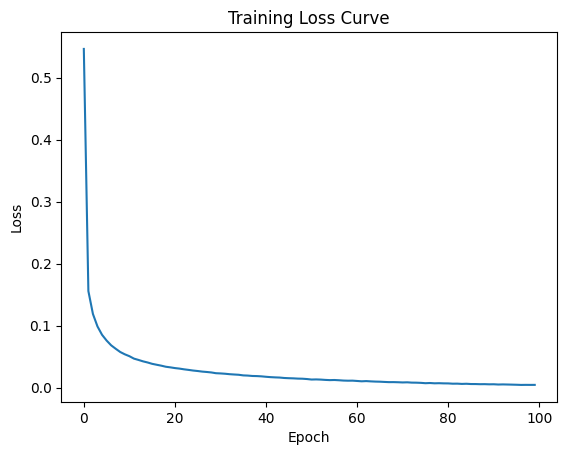

In [10]:
#可视化指标
def plot_losses(losses):
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()
plot_losses(losses)

In [11]:
#评估模型
def evaluate_model(model, testloader):
    model.eval()  # 设置模型为评估模式，模型不会梯度计算，不会更新参数
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)   # 前向传播
            _, predicted = torch.max(outputs, 1)  # 获取预测结果，返回向量第一列10维中最大的数字及其索引，_代表不关心第一个返回值
            y_true.extend(labels.numpy())   # 将真实标签添加到列表中
            y_pred.extend(predicted.numpy())   # 将预测标签添加到列表中

    accuracy = accuracy_score(y_true, y_pred)   # 计算准确率
    precision = precision_score(y_true, y_pred, average='macro')   # 计算精确率
    recall = recall_score(y_true, y_pred, average='macro')   # 计算召回率
    f1 = f1_score(y_true, y_pred, average='macro')   # 计算F1分数
    conf_matrix = confusion_matrix(y_true, y_pred)   # 计算混淆矩阵
    return accuracy, precision, recall, f1, conf_matrix

Accuracy: 0.9895833333333334
Precision: 0.9896069509719787
Recall: 0.9895339023935541
F1: 0.989547691071126


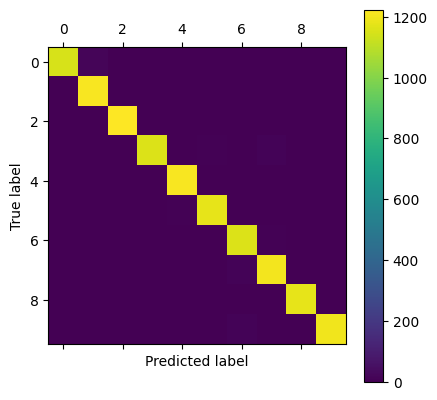

In [12]:
#评估模型的混淆矩阵可视化
accuracy, precision, recall, f1, conf_matrix=evaluate_model(model, test_dataloader)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
plt.matshow(conf_matrix, cmap='viridis')  # 绘制混淆矩阵
plt.colorbar()  # 显示颜色条
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [13]:
#目的：分类kannada手写数字
target_label=[]
nums=test.shape[0]
target_1d_list=test.values[:,1:]
target_2d_list=target_1d_list.reshape(nums,28,28,1)
for image in target_2d_list:
    target=image.reshape(1, 28, 28).astype('float32')
    target= torch.from_numpy(target)
    output = model(target)
    _, predicted = torch.max(output, 1)
    target_label.append(predicted.item())  

In [14]:
#输出
result=[]
for index, value in enumerate(target_label):
    result.append([index,value])
file_path = 'submission.csv'
df = pd.DataFrame(result, columns=['id', 'label'])
df.to_csv(file_path, index=False)

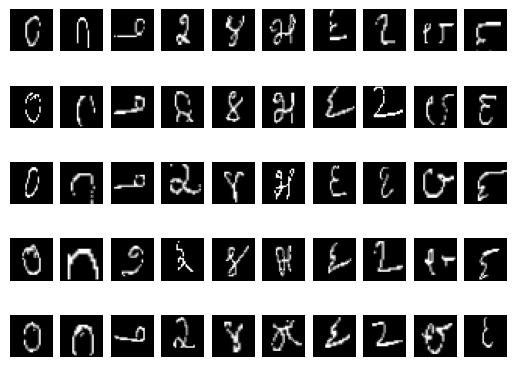

In [15]:
draw_pics(target_2d_list,target_label)